#### Download Satellite and Maps data

In [1]:
#Download the data
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

--2020-10-11 11:05:27--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  25.8MB/s    in 9.3s    

2020-10-11 11:05:37 (25.6 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [2]:
#Check if file has been downloaded
!ls -l

total 244388
-rw-r--r-- 1 root root 250242400 Sep  2  2018 maps.tar.gz
drwxr-xr-x 1 root root      4096 Oct  5 16:31 sample_data


In [3]:
#Unzip zip file
!tar -xzf maps.tar.gz

In [4]:
#Confirm if file has been unzipped
!ls -l

total 244392
drwxrwxrwx 4 8140  779      4096 Dec  3  2016 maps
-rw-r--r-- 1 root root 250242400 Sep  2  2018 maps.tar.gz
drwxr-xr-x 1 root root      4096 Oct  5 16:31 sample_data


In [5]:
!ls -l maps

total 68
drwxrwxrwx 2 8140 779 36864 Dec  3  2016 train
drwxrwxrwx 2 8140 779 32768 Dec  3  2016 val


In [6]:
#Number of training files
!ls -l maps/train | wc -l

1097


In [7]:
#Number of test files
!ls -l maps/val | wc -l

1099


#### Vizualize data

In [8]:
import tensorflow as tf
import os
import numpy as np

In [9]:
#Get a list of all training files
train_img_files = os.listdir('maps/train')
test_img_files = os.listdir('maps/val')

Original image size (1200, 600)


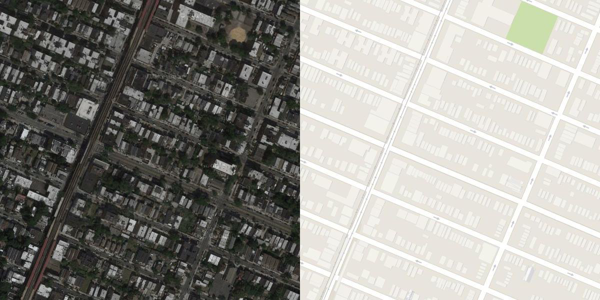

In [10]:
#Visualize a random image
img_num = np.random.randint(0, len(train_img_files))
img = tf.keras.preprocessing.image.load_img('./maps/train/' + train_img_files[img_num])
print('Original image size', img.size)
img_resized = img.resize((600,300))
img_resized

In [11]:
#Define input image size
img_height = 128
img_width = 128
img_depth = 3

#### Buid Generator

In this case, the input will be an Image (Satelite image) and output will be Map image. As we are having image as input and output, you can use a U-NET as generator.

Function to create two Convolutional layer block

In [12]:
def conv2d_block(input_tensor, n_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # second layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [13]:
def build_generator(input_img, n_filters=16, dropout=0.1):

    #ENCODER - DOWNSAMPLE the image

    #First Block
    c1 = conv2d_block(input_img, n_filters*1) #128x128x16
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(dropout)(p1)
    #output will be 64x64x16 for image size 128x128x1

    #Second Block
    c2 = conv2d_block(p1, n_filters*2) #64x64x32
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(dropout)(p2)
    #output will be 32x32x32

    #Third Block
    c3 = conv2d_block(p2, n_filters*4) 
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(dropout)(p3)
    #output will be 16x16x64

    #Fourth Block
    c4 = conv2d_block(p3, n_filters*8)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout)(p4)
    ##output will be 8x8x128 

    #Fifth Block
    c5 = conv2d_block(p4, n_filters*16)
    #output will be 8x8x256

    #We now have output of Encoder

    #DECODER - UPSAMPLE the feature to generate mask

    #First Block - connected to fourth block on DOWNSAMPLE side
    u6 = tf.keras.layers.Conv2DTranspose(n_filters * 8, (3, 3), 
                                         strides = (2, 2), 
                                         padding = 'same')(c5) #16x16x128
    u6 = tf.keras.layers.concatenate([u6, c4]) #16x16x256
    u6 = tf.keras.layers.Dropout(dropout)(u6) 
    c6 = conv2d_block(u6, n_filters * 8) #16x16x128

    #Second Block - connected to third block on DOWNSAMPLE side
    u7 = tf.keras.layers.Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4)

    #Third Block - connected to second block on DOWNSAMPLE side
    u8 = tf.keras.layers.Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2)

    #Fourth Block - connected to first block on DOWNSAMPLE side
    u9 = tf.keras.layers.Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1) #128 x 128 x 16

    #Build the Output layer
    outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(c9) #128x128x1

    #Build the model using different layers
    model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
    
    return model

#### Build Discriminator
Write a function to build a discriminator model. Discriminator's input will be images (both Satelite and Map images). Also discriminator will get real and fake images.

In [14]:
def build_discriminator(satelite_input, map_input):
    
    #Network parameters
    filter_size = 5
    num_filters = [32, 64, 128, 256]
    stride_size = [2, 2, 2, 1]
    
    #Build the network
    #Concatenate map image and satelite image
    x = tf.keras.layers.concatenate([satelite_input, map_input])
    
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(256, kernel_size=[5,5], strides=1, padding='same')(x)
    
    #Flatten the output and build an output layer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    #Build Model
    discriminator = tf.keras.models.Model([satelite_input, map_input],
                                          x, name='discriminator')
    
    return discriminator

#### Building Models for training
Write a function to create Generator, Discriminator and Adversarial model

In [15]:
def build_models():
    
    lr = 2e-4
    decay = 6e-8
    
    #Build input layers
    satelite_input = tf.keras.layers.Input(shape=(img_height,img_width,img_depth,)) #Input layer for satelite images
    map_input = tf.keras.layers.Input(shape=(img_height,img_width,img_depth,)) #Input layer for map images

    #Build Base Discriminator model    
    base_discriminator = build_discriminator(satelite_input, map_input)
    
    #Define discriminator, optimizer and compile model
    discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    optimizer = tf.keras.optimizers.RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    
    #Build Frozen Discriminator
    frozen_discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    #Freeze the weights of discriminator during adversarial training
    frozen_discriminator.trainable = False

    #Build Generator model
    generator = build_generator(satelite_input)
    
    #Build Adversarial model
    optimizer = tf.keras.optimizers.RMSprop(lr=lr * 0.5, decay=decay * 0.5)
        
    #Adversarial = generator + discriminator
    adversarial = tf.keras.models.Model(satelite_input,
                                        frozen_discriminator([satelite_input, generator(satelite_input)]))
    
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])    
    
    return generator, discriminator, adversarial

#### Training Discriminator and Adversarial Models
Write a function to train Discriminator and Adversarial model in sequential manner

Function to generate training data - batch by batch

In [16]:
def batch_generator(img_files, batch_size=16):

    while True:
        
        sat_images = np.zeros((batch_size, img_height, img_width, img_depth))
        map_images = np.zeros((batch_size, img_height, img_width, img_depth))

        idx = np.random.randint(0, len(img_files), batch_size)

        for i in range(batch_size):
            img_num = idx[i]
            img = tf.keras.preprocessing.image.load_img('./maps/train/' + img_files[img_num],target_size=(img_height, img_width*2))
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            sat_images[i] = img_array[:, :img_width, :]
            map_images[i] = img_array[:, img_width:, :]

        sat_images /= 255.
        map_images /= 255.

        yield sat_images, map_images

In [17]:
def train_gan(generator, discriminator, adversarial, 
              train_steps=100, batch_size=64):
    
    #Initialize train and test generator
    train_generator =  batch_generator(train_img_files, batch_size=batch_size)
    test_generator =  batch_generator(test_img_files, batch_size=5)
    
    #Input for testing generator at different intervals, we will generate 16 images
    test_satelite_input, test_map_actual = next(test_generator)
    
    #Start training
    for i in range(train_steps):
        
        #Train DISCRIMATOR
        
        #Get input data for generator
        gen_sat_images, _ = next(train_generator)

        #1. Get fake images from Generator
        fake_map_images = generator.predict(gen_sat_images)

        #2. Get real input data for discriminator
        sat_images, map_images = next(train_generator)
        
        #3. Prepare input for training Discriminator
        X_sat_images = np.concatenate((sat_images, gen_sat_images)) 
        X_map_images = np.concatenate((map_images, fake_map_images)) 
        
        #4. Labels for training
        y_real = np.ones((batch_size, 1))
        y_fake = np.zeros((batch_size, 1))
        y = np.concatenate((y_real, y_fake))
        
        #5. Train Discriminator
        d_loss, d_acc = discriminator.train_on_batch([X_sat_images, X_map_images], y)
        
        
        #Train ADVERSARIAL Network
        
        #1. Prepare input - create a new batch of images
        gen_sat_images, _ = next(train_generator)

        #2. Prepare labels - training Adversarial network to lie :) - All 1s
        y = np.ones((batch_size, 1)) #64, 1
        
        #3. Train - Pls note Discrimator is not getting trained here
        a_loss, a_acc = adversarial.train_on_batch(gen_sat_images, y)
        
        if i % 50 == 0:
            #Print loss and Accuracy for both networks
            print("%s [Discriminator loss: %f, acc: %f, Adversarial loss: %f, acc: %f]" % (i, d_loss, d_acc, a_loss, a_acc) )
        
        #Save generated images to see how well Generator is doing
        if (i+1) % 200 == 0:
            
            #Generate map images
            fake_map_images = generator.predict(test_satelite_input)
            
            #Display images
            plot_images(test_satelite_input, test_map_actual, fake_map_images)
            
    #Save Generator model
    generator.save('satelite_map_cgan.h5')   

#### Function to display Generator images

In [18]:
from matplotlib import pyplot as plt

In [19]:
def plot_images(real_satelite, real_map, generated_map):
    
    plt.figure(figsize=(15, 10))
    num_images = real_satelite.shape[0]
    
    for i in range(num_images):
        plt.subplot(num_images, num_images, i + 1)
        plt.imshow(real_satelite[i])
        plt.axis('off')
    for i in range(num_images):
        plt.subplot(num_images, num_images, num_images + i + 1)
        plt.imshow(real_map[i])
        plt.axis('off')
    for i in range(num_images):
        plt.subplot(num_images, num_images, 2*num_images + i + 1)
        plt.imshow(generated_map[i])
        plt.axis('off')
    
    plt.show()    

#### Start GAN training

In [20]:
tf.keras.backend.clear_session()
G, D, A = build_models()

In [21]:
G.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [22]:
D.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 6)  0           concatenate[0][0]     

In [23]:
A.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
functional_5 (Functional)       (None, 128, 128, 3)  2164627     input_1[0][0]                    
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 1)            1146017     input_1[0][0]                    
                                                                 functional_5[0][0]               
Total params: 3,310,644
Trainable params: 2,161,683
Non-trainable params: 1,148,961
__________________________________________________________________________________________________


In [24]:
train_gan(G, D, A, train_steps=100)

0 [Discriminator loss: 0.688185, acc: 0.500000, Adversarial loss: 0.018883, acc: 1.000000]
50 [Discriminator loss: 0.479812, acc: 0.781250, Adversarial loss: 0.183484, acc: 0.953125]


In [25]:
train_gan(G, D, A, train_steps=2000)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
train_gan(G, D, A, train_steps=2000)

Output hidden; open in https://colab.research.google.com to view.